# **The Navier-Stokes equatio**
**Johan Hoffman**



Order version 
 plot the title "drag" is the drag coeff
 plot with the title "drag coefficient" is not.

In [ ]:
# Load neccessary modules.
from google.colab import files
import sys
import numpy as np
import time

# Install FEniCS
try:
    import dolfin
except ImportError as e:
    !apt-get install -y -qq software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    !sed -i "s|#if PETSC_VERSION_MAJOR == 3 && PETSC_VERSION_MINOR <= 8 && PETSC_VERSION_RELEASE == 1|#if 1|" /usr/include/dolfin/la/PETScLUSolver.h
    !rm -rf /usr/lib/python3/dist-packages/mpi4py*
    !rm -rf /usr/lib/python3/dist-packages/petsc4py*
    !rm -rf /usr/lib/python3/dist-packages/slepc4py*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/dolfin*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/mshr*
    !wget "https://drive.google.com/uc?export=download&id=1cT_QBJCOW_eL3BThnval3bcpb8o0w-Ad" -O /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=119i49bxlGn1mrnhTNmOvM4BqmjrT9Ppr" -O /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-1tVfu8qz3bRC2zvR8n3RESpesWqNnn6" -O /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-3qY4VIJQaXVO1HfGQIzTIURIeJbvX-9" -O /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-5SMjgjMuee_9WLeYtGe8N_lvipWEN7W" -O /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !pip3 install /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 -q install --upgrade sympy
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic InRelease [15.4 kB]
Get:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:13 https://developer.download.n

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term, which also functions as a residual based turbulence model. To model turbulent boundary layers, we use a skin friction boundary condition. 

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula: 

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization, 

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder). 

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g. 

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


In [ ]:
# Define rectangular domain 
L = 4
H = 3

def generating_mesh(resolution, xc, yc, rc, no_levels=0):
  # Generate mesh (examples with and without a hole in the mesh) 
  #mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
  mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc,32) - 
                       Circle(Point(1.1,1.65),0.05,8) - Circle(Point(1.1,1.35),0.05,8) -
                       Circle(Point(1,  1.68),0.05,8) - Circle(Point(1,   1.32),0.05,8) -
                       Circle(Point(0.9,1.65),0.05,8) - Circle(Point(0.9,1.35),0.05,8) - Circle(Point(0.83,1.5),0.05,8),
                       resolution)
      # Local mesh refinement (specified by a cell marker)
  for i in range(0,no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for cell in cells(mesh):
      cell_marker[cell] = False
      p = cell.midpoint()
      if p.distance(Point(xc, yc)) < 1:
          cell_marker[cell] = True
    mesh = refine(mesh, cell_marker)

  return mesh

In [ ]:
# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

class Skin_Friction(SubDomain):
    def inside(self, x, on_boundary):
        return (on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) \
                and (not near(x[1], 0.0)) and (not near(x[1], H)))
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()
skin_friction = Skin_Friction()

class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

In [ ]:
def generate_sol(mesh, nu, turbulent_model_type = 1, direction = 'y', inflow = 1, beta = 0):

  # Define mesh functions (for boundary conditions)
  boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
  boundaries.set_all(0)
  left.mark(boundaries, 1)
  right.mark(boundaries, 2)
  lower.mark(boundaries, 3)
  upper.mark(boundaries, 4)
  skin_friction.mark(boundaries, 5)

  # Generate finite element spaces (for velocity and pressure)
  V = VectorFunctionSpace(mesh, "Lagrange", 2)
  Q = FunctionSpace(mesh, "Lagrange", 2)

  # Define trial and test functions 
  u = TrialFunction(V)
  p = TrialFunction(Q)
  v = TestFunction(V)
  q = TestFunction(Q)



  dbc_lower = DirichletBoundaryLower()
  dbc_upper = DirichletBoundaryUpper()
  dbc_left = DirichletBoundaryLeft()
  dbc_right = DirichletBoundaryRight()
  dbc_objects = DirichletBoundaryObjects()

  # Examples of time dependent and stationary inflow conditions
  #uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
  #uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
  uin = inflow
  bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
  bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
  bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
  bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
  bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
  bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
  bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
  bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

  pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
  pout = 0.0
  #bcp0 = DirichletBC(Q, pin, dbc_left) 
  bcp1 = DirichletBC(Q, pout, dbc_right)

  #bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
  
  if turbulent_model_type:
  #bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
    bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1]

    print("turbulent model used")
  if not turbulent_model_type:
    bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
  bcp = [bcp1]

  # Define measure for boundary integration  
  ds = Measure('ds', domain=mesh, subdomain_data=boundaries)


  # Define iteration functions
  # (u0,p0) solution from previous time step
  # (u1,p1) linearized solution at present time step  
  u0 = Function(V)
  u1 = Function(V)
  p0 = Function(Q)
  p1 = Function(Q)

  # Set parameters for nonlinear and lienar solvers 
  num_nnlin_iter = 5 
  prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

  # Time step length 
  dt = 0.5*mesh.hmin() 

  # Define variational problem

  # Stabilization parameters
  h = CellDiameter(mesh);
  u_mag = sqrt(dot(u1,u1))
  d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
  d2 = h*u_mag

  # Skin friction boundary conditions, implemented as 
  # penalty terms, defined in terms 
  # of the normal and tangent vectors
  normal = FacetNormal(mesh)
  tangent = as_vector([normal[1], -normal[0]])
  C_alpha = 1.0e2
  alpha = C_alpha/h
  #beta = 0.0
  #beta = 100

  # Mean velocities for trapozoidal time stepping
  um = 0.5*(u + u0)
  um1 = 0.5*(u1 + u0) 

  # Momentum variational equation on residual form

  if turbulent_model_type:
    Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
        + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx \
        + alpha*(inner(dot(um,normal), dot(v,normal)))*ds(5) + beta*(inner(dot(um,tangent), dot(v,tangent)))*ds(5) 
    assert turbulent_model_type == True

  if not turbulent_model_type:
    Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
        + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx
    assert turbulent_model_type == False
  au = lhs(Fu)
  Lu = rhs(Fu)

  # Continuity variational equation on residual form
  Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx 
  ap = lhs(Fp)
  Lp = rhs(Fp)

  # Define the direction of the force to be computed 
  phi_x = 0.0
  phi_y = 0.0
  if direction == 'y':
    phi_y = 1.0
  if direction == 'x':
    phi_x = 1.0

  #psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
  #psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
  #psi = interpolate(psi_expression, V)

  #Force = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

  #plt.figure()
  #plot(psi, title="weight function psi")

  # Force normalization
  D = 2*rc
  normalization = -2.0/D

  # Open files to export solution to Paraview
  #file_u = File("results-NS/u.pvd")
  #file_p = File("results-NS/p.pvd")

  # Set plot frequency
  plot_time = 0
  plot_freq = 10

  # Force computation data 
  force_array = np.array(0.0)
  force_array = np.delete(force_array, 0)
  time = np.array(0.0)
  time = np.delete(time, 0)
  start_sample_time = 1.0

  #!rm results-NS/*

  # Time stepping 
  T = 20
  t = dt

  while t < T + DOLFIN_EPS:

      #s = 'Time t = ' + repr(t) 
      #print(s)

      pin.t = t
     #uin.t = t

      # Solve non-linear problem 
      k = 0
      while k < num_nnlin_iter: 
        
          # Assemble momentum matrix and vector 
          Au = assemble(au)
          bu = assemble(Lu)
          # Compute velocity solution 
          [bc.apply(Au, bu) for bc in bcu]
          [bc.apply(u1.vector()) for bc in bcu]
          solve(Au, u1.vector(), bu, "bicgstab", "default")
          # Assemble continuity matrix and vector
          Ap = assemble(ap) 
          bp = assemble(Lp)
          # Compute pressure solution 
          [bc.apply(Ap, bp) for bc in bcp]
          [bc.apply(p1.vector()) for bc in bcp]
          solve(Ap, p1.vector(), bp, "bicgstab", prec)
          # Compute force
          F = assemble(Force)
          if (t > start_sample_time):
            force_array = np.append(force_array, normalization*F)
            time = np.append(time, t)
          k += 1
      u0.assign(u1)
      t += dt

  return u1, p1, time, force_array

#!tar -czvf results-NS.tar.gz results-NS
#files.download('results-NS.tar.gz')

# **Mesh**

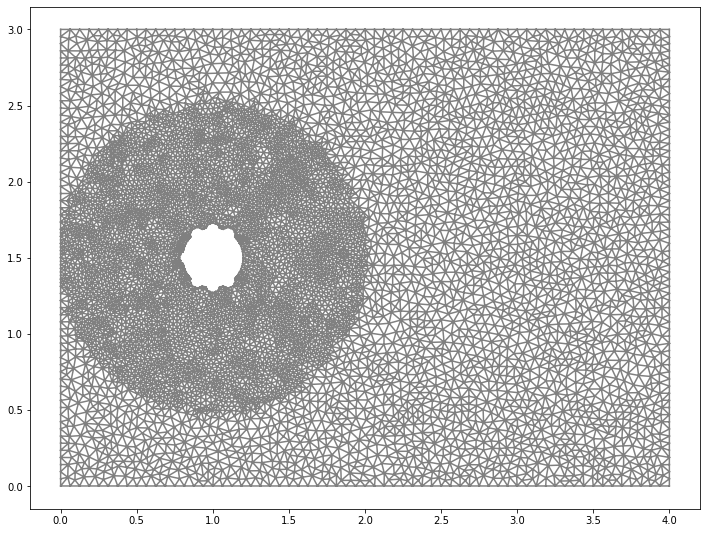

In [ ]:
# Define parameters
xc = 0.25*L
yc = 0.5*H
rc = 0.2

resolution = 60
mesh = generating_mesh(resolution, xc, yc, rc, no_levels=1)

plt.figure(figsize=(12,10))
plot(mesh)
plt.show()


In [ ]:
# Set viscosity
nu = 4.0e-3
# Set velocity
inflow = 1
Re = inflow*2*rc/nu
if Re > 10**6:
  tu = True
elif Re < 10**5:
  tu = False
else:
  sys.exit()

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


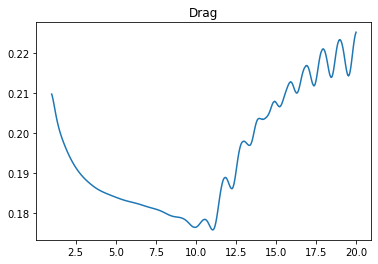

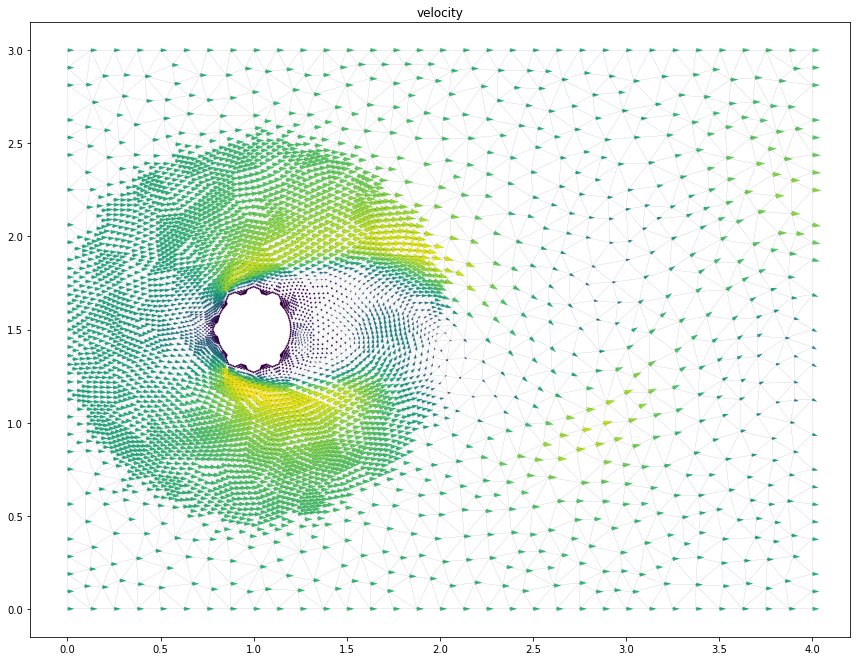

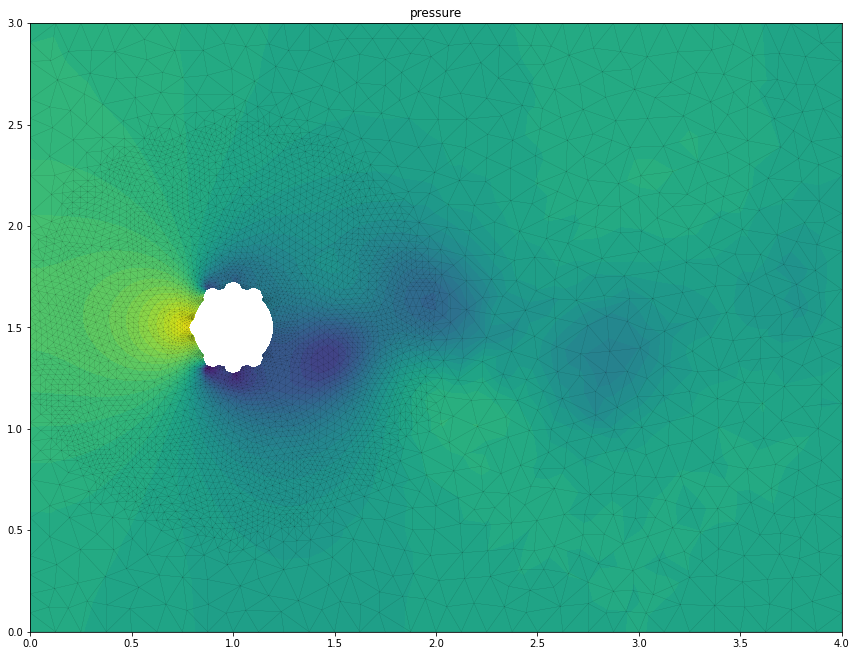

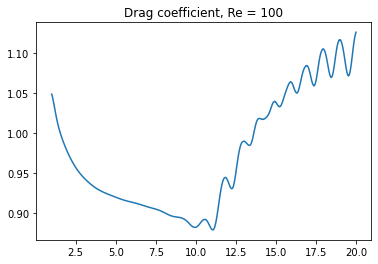

In [ ]:
velocity, pressure, time, force = generate_sol(mesh, nu, tu, 'x')
plt.figure()
plt.title("Drag")
plt.plot(time, force)
plt.show()
plt.figure(figsize=(12,10))
plot(mesh, linewidth=0.1, color="k", alpha=0.7)
plot(velocity,title="velocity")
plt.tight_layout()
plt.show()
plt.figure(figsize=(12,10))
plot(mesh, linewidth=0.1, color="k", alpha=0.7)
plot(pressure,title="pressure")
plt.tight_layout()
plt.show()


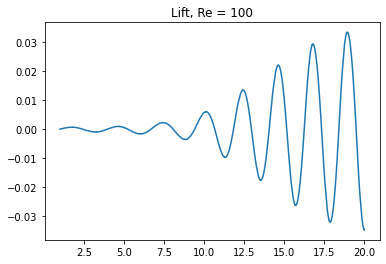

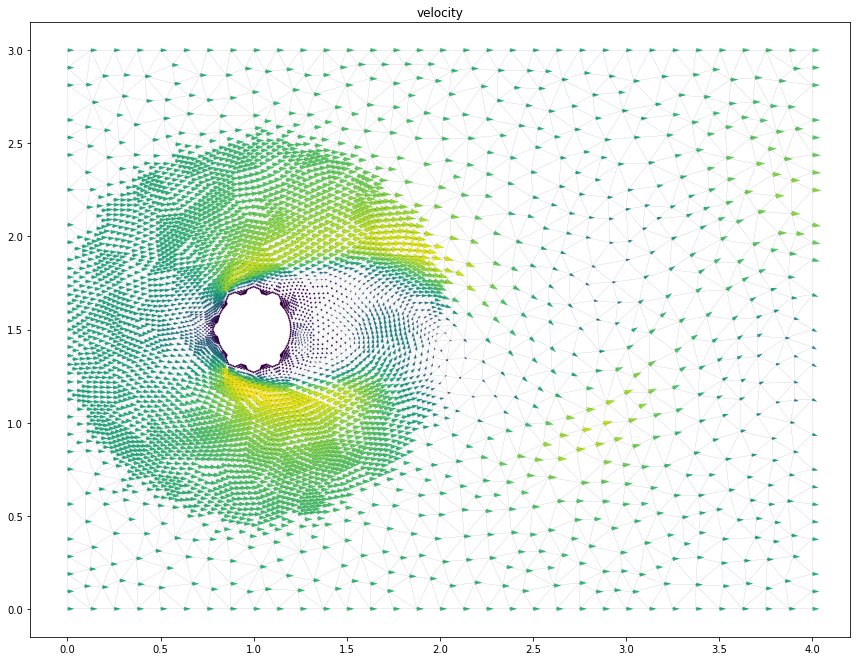

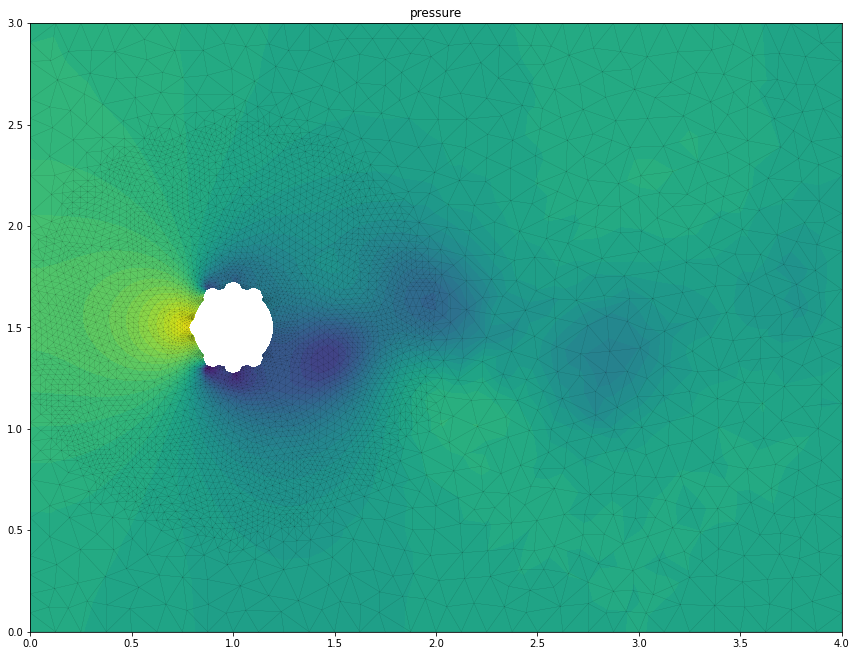

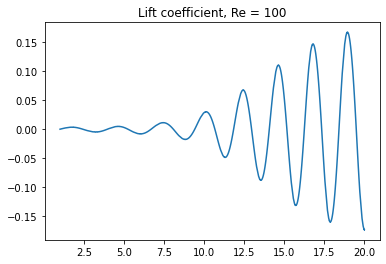

In [ ]:
velocity, pressure, time, force = generate_sol(mesh, nu, tu, 'y')
plt.figure()
plt.title( 'Lift, Re = '+ str(round(Re)))
plt.plot(time, force)
plt.show()
plt.figure(figsize=(12,10))
plot(mesh, linewidth=0.1, color="k", alpha=0.7)
plot(velocity,title="velocity")
plt.tight_layout()
plt.show()
plt.figure(figsize=(12,10))
plot(mesh, linewidth=0.1, color="k", alpha=0.7)
plot(pressure,title="pressure")
plt.tight_layout()
plt.show()

plt.figure()
coefficient = 2*force/(2*rc)
plt.plot(time,coefficient)
plt.title( 'Lift coefficient, Re = '+ str(round(Re)))
plt.show()


In [ ]:
# Set viscosity
nu = 4.0e-4
# Set velocity
inflow = 1
Re = inflow*2*rc/nu
if Re > 10**6:
  tu = True
elif Re < 10**5:
  tu = False
else:
  sys.exit()

In [ ]:
velocity, pressure, time, force = generate_sol(mesh, nu, False, 'x', inflow, 30)
plt.figure()
plt.title("Drag")
plt.plot(time, force)
plt.show()
plt.figure(figsize=(12,10))
plot(mesh, linewidth=0.1, color="k", alpha=0.7)
plot(velocity,title="velocity")
plt.tight_layout()
plt.show()
plt.figure(figsize=(12,10))
plot(mesh, linewidth=0.1, color="k", alpha=0.7)
plot(pressure,title="pressure")
plt.tight_layout()
plt.show()

plt.figure()
coefficient = 2*force/(2*rc)
plt.plot(time,coefficient)
plt.title( 'Drag coefficient, Re = '+ str(round(Re)))
plt.show()